In [1]:
!pip install tidy3d
import tidy3d.web as web
web.configure("wclpAIGF4JlvJlABZs9BOY3yg53fsAAd54VzLiVcCFPu7pFC")

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.2
    Uninstalling numpy-1.23.2:
      Successfully uninstalled numpy-1.23.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
oldest-supported-numpy 2023.12.21 requires numpy==1.23.2; python_version == "3.11", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\adas24\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Configured successfully.


In [2]:
!pip install gdstk

  Using cached numpy-1.23.2-cp311-cp311-win_amd64.whl.metadata (2.2 kB)
Using cached numpy-1.23.2-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.2 which is incompatible.
jax 0.4.31 requires numpy>=1.24, but you have numpy 1.23.2 which is incompatible.
jaxlib 0.4.31 requires numpy>=1.24, but you have numpy 1.23.2 which is incompatible.
ml-dtypes 0.4.0 requires numpy>=1.23.3; python_version >= "3.11", but you have numpy 1.23.2 which is incompatible.
scipy 1.14.0 requires numpy<2.3,>=1.23.5, but you have numpy 1.23.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\adas24\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.resonance import ResonanceFinder

import gdstk

In [43]:
lambda_min = 0.8
lambda_max = 1.1

monitor_lambda = np.linspace(lambda_min, lambda_max, 101)
monitor_freq = td.constants.C_0/monitor_lambda

dl = 0.02 # uniform sampling mesh size

sim_size = Lx, Ly, Lz = (4, 4, 2)
offset_monitor = 0 # monitor position in the vertical direction

vacuum = td.Medium(permittivity = 1, name = 'vacuum')
GaAs_permittivity = 3.55**2
GaAs = td.Medium(permittivity = GaAs_permittivity, name = 'GaAs')

freq0 = 302.675e12 # taken from the Lumerical file supplied by Dr. Dima
fwidth = 144.131e12 #
freq0 = 302.675e12 # taken from the Lumerical file supplied by Dr. Dima

slab_side_length = 10
slab_height = 0.2

t_start = 10/fwidth  # from inspection
t_stop = 1.8e-12

In [44]:
slab = td.Structure(
    geometry = td.Box(
        center = (0, 0, 0),
        size = (slab_side_length, slab_side_length, slab_height)
    ),
    medium = GaAs,
    name = 'GaAs slab'
)

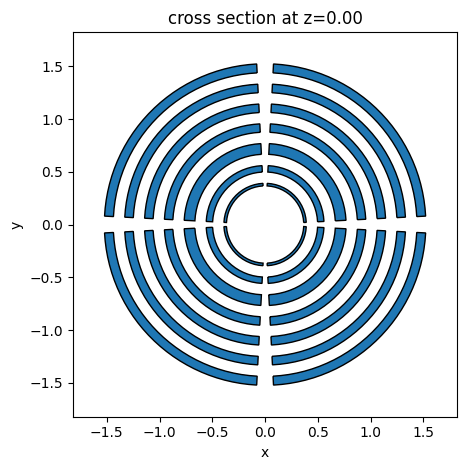

In [45]:
lib = gdstk.Library()

# Geometry must be placed in cells.
cell = lib.new_cell("BULLSEYE")

central_inner_radius = 0.355 + 0.011506275230097854               #initial inner radius
ring_width = 0.07 + np.array([-0.04582826, -0.00938296,  0.03156387,  0.00994485,  0.01060029,  0.0109359, 0.01434763])                #rings' width
ring_height = 0.2                   #rings' height
theta1 = 3 * np.pi / 180
theta2 = 87 * np.pi / 180
ringsNumbers = 7
vertexIncrement = 0.1075 
ringNumber = 7
xOrigin = 0
yOrigin = 0

inner_radius = central_inner_radius

for i in range(ringsNumbers):

    outer_radius = inner_radius + ring_width[i]
    for j in range(4):

        gcSlice = gdstk.ellipse(
            (xOrigin, yOrigin),
            inner_radius,
            outer_radius,
            theta1 + j*np.pi/2,
            theta2 + j*np.pi/2,
            layer=1,
            datatype=1,
            tolerance=0.0005
        )
        cell.add(gcSlice)

    

    inner_radius = outer_radius + vertexIncrement

gc_etch = td.Geometry.from_gds(
        cell, gds_layer=1, axis=2, slab_bounds=(-ring_height/2, ring_height/2)
    )

gc_etch.plot(z=0)
plt.show()

In [46]:
mat_etch = td.Medium(permittivity = 1, name = 'air')
etch = td.Structure(
    geometry = gc_etch,
    medium = mat_etch,
    name = 'etch'
)

In [47]:
dipole_source = td.PointDipole(
    center = (0, 0, 0),
    source_time = td.GaussianPulse(
        freq0 = freq0,
        fwidth = fwidth),
    polarization = 'Ex',
    name = 'dipole_source'
)

In [48]:
time_monitor_1 = td.FieldTimeMonitor(
    name = 'time_monitor_1',
    size = [0, 0, 0],
    center = [0.1, 0.1, 0],
    start = t_start
)

time_monitor_2 = td.FieldTimeMonitor(
    name = 'time_monitor_2',
    size = [0, 0, 0],
    center = [0.1, 0.2, 0],
    start = t_start
)

time_monitor_3 = td.FieldTimeMonitor(
    name = 'time_monitor_3',
    size = [0, 0, 0],
    center = [0.2, 0.2, 0],
    start = t_start
)

time_monitor_4 = td.FieldTimeMonitor(
    name = 'time_monitor_4',
    size = [0, 0, 0],
    center = [0.2, 0.1, 0],
    start = t_start
)

time_monitors = [time_monitor_1, time_monitor_2, time_monitor_3, time_monitor_4]
     


In [49]:
sim_Q = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl = dl),
    run_time = t_stop,
    sources = [dipole_source],
    monitors = time_monitors,
    structures = [slab, etch],
    medium = vacuum,
    shutoff = 1e-7,
    symmetry = [-1, 1, 0]
)

13:42:04 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

In [50]:

sim_Q.plot_3d()

In [51]:
task_id = web.upload(sim_Q, task_name = 'ConvergenceIndividiualRingCentRingGmax=5Epoch=15_1point_8_ps')
     

13:42:17 Eastern Standard Time Created task                                     
                               'ConvergenceIndividiualRingCentRingGmax=5Epoch=15
                               _1point_8_ps' with task_id                       
                               'fdve-49db8978-9731-40e8-98df-0df8cfc564d1' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=612822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=115492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\taskId]8;;\
                               ]8;id=612822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\=]8;;\]8;id=293217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\fdve]8;;\]8;id=612822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\-49db8978-9731-40e8-98df-0df8cfc564d1']8;;\.

Output()

In [52]:
web.start(task_id)
web.monitor(task_id, verbose = True)

13:42:22 Eastern Standard Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

13:42:27 Eastern Standard Time status = preprocess

13:42:28 Eastern Standard Time You are running this simulation for FREE. Your   
                               current plan allows up to 20 free non-concurrent 
                               simulations per day (under 100.0M grid points and
                               50.0K time steps)

                               starting up solver

                               running solver

Output()

13:42:51 Eastern Standard Time status = postprocess

Output()

13:42:53 Eastern Standard Time status = success

                               View simulation result at                        
                               ]8;id=473578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=620428;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\taskId]8;;\
                               ]8;id=473578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\=]8;;\]8;id=254489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\fdve]8;;\]8;id=473578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49db8978-9731-40e8-98df-0df8cfc564d1\-49db8978-9731-40e8-98df-0df8cfc564d1']8;;\.

In [53]:
sim_data = web.load(task_id, path='data/ConvergenceIndividiualRingIndividualDistCentRingGmax=5Epoch=15_1_point_8ps.hdf5')
print(sim_data.log)

Output()

13:43:35 Eastern Standard Time loading simulation from                          
                               data/ConvergenceIndividiualRingIndividualDistCent
                               RingGmax=5Epoch=15_1_point_8ps.hdf5

                               WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

                               WARNING: Simulation final field decay value of   
                               0.0649 is greater than the simulation shutoff    
                               threshold of 1e-07. Consider running the         
                               simulation again with a larger 'run_time'        
                               duration for more accurate results.              

                               WARNING: Warning messages were found in the      
                               solver log. For more information, check          
                               'SimulationData.log' or use                      
                               'web.download_log(task_id)'.                     

[18:42:26] WARNING: Structure at structures[1] was detected as being less than  
           half of a central wavelength from a PML on side x-min. To avoid      
           inaccurate results or divergence, please increase gap between any    
           structures and PML or fully extend structure through the pml.        
           USER: Simulation domain Nx, Ny, Nz: [224, 224, 124]                  
           USER: Applied symmetries: (-1, 1, 0)                                 
           USER: Number of computational grid points: 1.6375e+06.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of t

In [54]:

sim_data = td.SimulationData.from_file(fname = 'data/ConvergenceIndividiualRingIndividualDistCentRingGmax=5Epoch=15_1_point_8ps.hdf5')

13:43:45 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

In [55]:
resonance_finder = ResonanceFinder(freq_window=(monitor_freq[-1], monitor_freq[0]))
resonance_data = resonance_finder.run(signals=sim_data.data)
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
2.272622e+14,-1.495176e+14,-4.775128,47.428351,1.251743,3.524343
2.646336e+14,2.300273e+13,36.142269,43.485505,-0.021658,0.365394
2.704864e+14,5.306284e+12,160.141806,13.797975,2.247653,0.164652
2.856527e+14,4.048826e+12,221.645590,40.282116,2.200229,0.100358
3.218253e+14,1.639733e+12,616.590450,78.959906,0.053479,0.045119
3.258628e+14,6.920941e+11,1479.174924,107.175631,-1.403134,0.052011
3.500539e+14,2.852792e+12,385.491399,45.570361,-2.689073,0.074914
4.015423e+14,2.208105e+12,571.296397,120.060106,-2.080566,0.047076
4.162672e+14,-1.643406e+13,-79.575093,328.819588,-2.709275,0.319476


C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:33: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ex = td.constants.C_0 / freqs_Ex
C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:34: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ey = td.constants.C_0 / freqs_Ey
C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:35: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ez = td.constants.C_0 / freqs_Ez


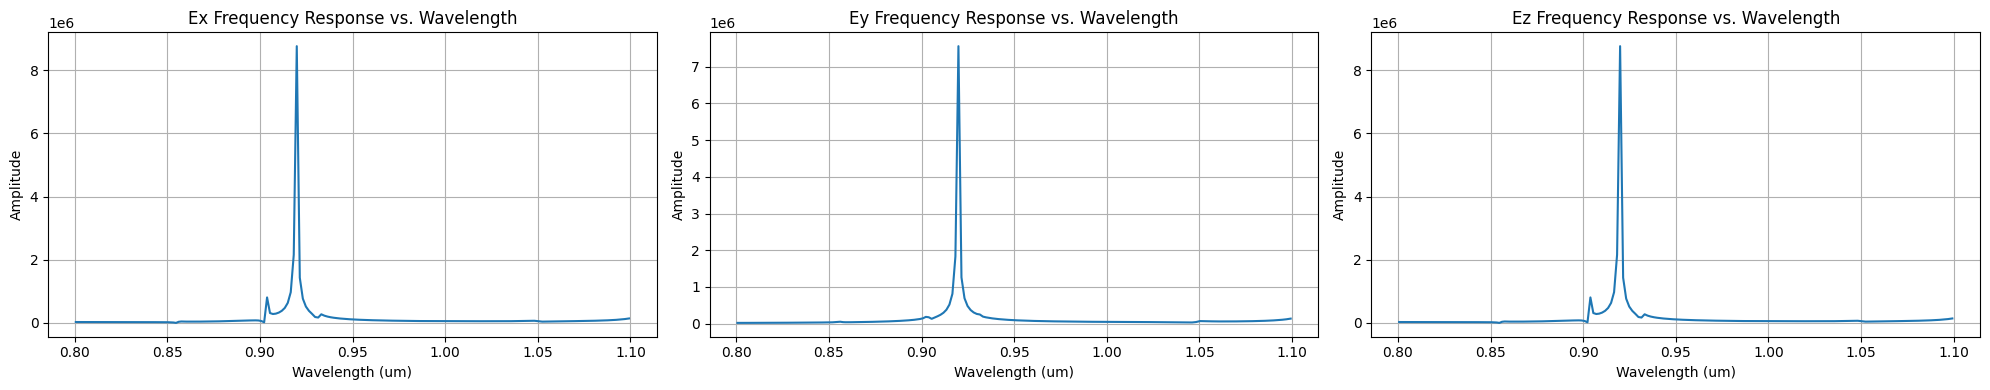

In [56]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

time_monitor_names = [monitor.name for monitor in time_monitors]

time_response_Ex = np.zeros_like(sim_data["time_monitor_1"].Ex.squeeze())
time_response_Ey = np.zeros_like(sim_data["time_monitor_1"].Ey.squeeze())
time_response_Ez = np.zeros_like(sim_data["time_monitor_1"].Ez.squeeze())

for monitor_name in time_monitor_names:
    time_response_Ex += sim_data[monitor_name].Ex.squeeze()
    time_response_Ey += sim_data[monitor_name].Ey.squeeze()
    time_response_Ez += sim_data[monitor_name].Ez.squeeze()

time_response_Ex /= len(time_monitor_names)
time_response_Ey /= len(time_monitor_names)
time_response_Ez /= len(time_monitor_names)


# Perform FFT and get the frequency response
freq_response_Ex = np.abs(np.fft.fft(time_response_Ex))
freq_response_Ey = np.abs(np.fft.fft(time_response_Ey))
freq_response_Ez = np.abs(np.fft.fft(time_response_Ez))

# Calculate the frequency values
freqs_Ex = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ex))
freqs_Ey = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ey))
freqs_Ez = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ez))

# Calculate the corresponding wavelengths
wavelengths_Ex = td.constants.C_0 / freqs_Ex
wavelengths_Ey = td.constants.C_0 / freqs_Ey
wavelengths_Ez = td.constants.C_0 / freqs_Ez

# Select the indices within the monitor frequency range
plot_inds_Ex = np.where((monitor_freq[-1] < freqs_Ex) & (freqs_Ex < monitor_freq[0]))
plot_inds_Ey = np.where((monitor_freq[-1] < freqs_Ey) & (freqs_Ey < monitor_freq[0]))
plot_inds_Ez = np.where((monitor_freq[-1] < freqs_Ez) & (freqs_Ez < monitor_freq[0]))

# Plot the frequency response with respect to wavelength
ax[0].plot(wavelengths_Ex[plot_inds_Ex], freq_response_Ex[plot_inds_Ex])
ax[0].set_xlabel("Wavelength (um)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Ex Frequency Response vs. Wavelength")
ax[0].grid(True)

ax[1].plot(wavelengths_Ey[plot_inds_Ey], freq_response_Ey[plot_inds_Ey])
ax[1].set_xlabel("Wavelength (um)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Ey Frequency Response vs. Wavelength")
ax[1].grid(True)

ax[2].plot(wavelengths_Ex[plot_inds_Ez], freq_response_Ex[plot_inds_Ez])
ax[2].set_xlabel("Wavelength (um)")
ax[2].set_ylabel("Amplitude")
ax[2].set_title("Ez Frequency Response vs. Wavelength")
ax[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')
     

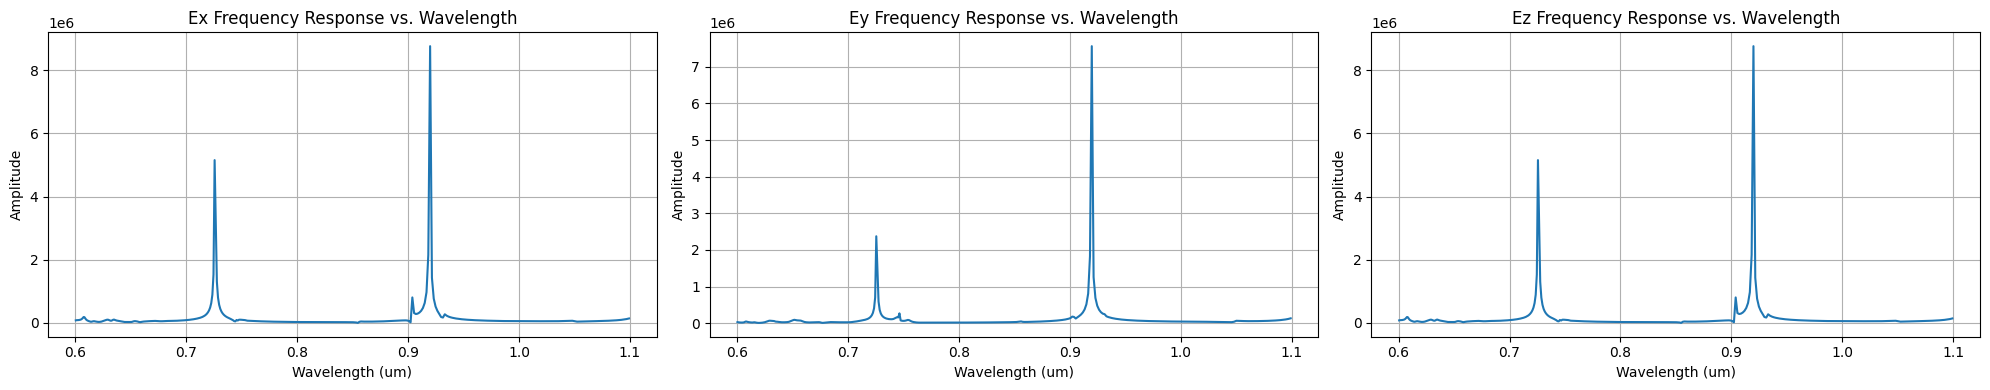

In [20]:
wavelength_short = np.array([0.6, 1.1])
freq_short = td.constants.C_0 / wavelength_short

plot_inds_Ex_short = np.where((freq_short[-1] < freqs_Ex) & (freqs_Ex < freq_short[0]))
plot_inds_Ey_short = np.where((freq_short[-1] < freqs_Ey) & (freqs_Ey < freq_short[0]))
plot_inds_Ez_short = np.where((freq_short[-1] < freqs_Ez) & (freqs_Ez < freq_short[0]))

fig, ax_short = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

# Plot the frequency response with respect to wavelength
ax_short[0].plot(wavelengths_Ex[plot_inds_Ex_short], freq_response_Ex[plot_inds_Ex_short])
ax_short[0].set_xlabel("Wavelength (um)")
ax_short[0].set_ylabel("Amplitude")
ax_short[0].set_title("Ex Frequency Response vs. Wavelength")
ax_short[0].grid(True)

ax_short[1].plot(wavelengths_Ey[plot_inds_Ey_short], freq_response_Ey[plot_inds_Ey_short])
ax_short[1].set_xlabel("Wavelength (um)")
ax_short[1].set_ylabel("Amplitude")
ax_short[1].set_title("Ey Frequency Response vs. Wavelength")
ax_short[1].grid(True)

ax_short[2].plot(wavelengths_Ex[plot_inds_Ez_short], freq_response_Ex[plot_inds_Ez_short])
ax_short[2].set_xlabel("Wavelength (um)")
ax_short[2].set_ylabel("Amplitude")
ax_short[2].set_title("Ez Frequency Response vs. Wavelength")
ax_short[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')

plt.show()

In [57]:
from scipy.signal import find_peaks

In [58]:
wavelength_subset = wavelengths_Ey[plot_inds_Ex_short]
freq_response_subset = freq_response_Ey[plot_inds_Ex_short]

frequency_subset = td.constants.C_0 / wavelength_subset

peak_idx = np.argmax(freq_response_subset)
f_center = frequency_subset[peak_idx]

half_max = (np.max(freq_response_subset)+ np.min(freq_response_subset)) /2
greater_half_max = freq_response_subset >= half_max
indices = np.where(greater_half_max)[0]

fwhm = frequency_subset[indices[-1]] - frequency_subset[indices[0]]

Q_factor = f_center /fwhm

# Display results
print(f"Central Frequency: {f_center:.4f} Hz")
print(f"FWHM: {fwhm:.4f} Hz")
print(f"Quality Factor (Q): {Q_factor:.2f}")

Central Frequency: 325891726619108.0625 Hz
FWHM: 0.0000 Hz
Quality Factor (Q): inf


C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\1790781779.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  Q_factor = f_center /fwhm


In [59]:
t_final  = 3.6e-12

In [ ]:
sim_Q = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl = dl),
    run_time = t_final,
    sources = [dipole_source],
    monitors = time_monitors,
    structures = [slab, etch],
    medium = vacuum,
    shutoff = 1e-7,
    symmetry = [-1, 1, 0]
)

13:44:54 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

In [62]:
task_id = web.upload(sim_Q, task_name = 'IndividiualRingCentRingGmax=5Epoch=15_3_point_6ps')
     

13:45:20 Eastern Standard Time Created task                                     
                               'IndividiualRingCentRingGmax=5Epoch=15_3_point_6p
                               s' with task_id                                  
                               'fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=290038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=96803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\taskId]8;;\
                               ]8;id=290038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\=]8;;\]8;id=547124;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\fdve]8;;\]8;id=290038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\-7bc6527f-660e-4fcb-b487-8d566ceaf977']8;;\.

Output()

In [63]:
web.start(task_id)
web.monitor(task_id, verbose="True")

13:45:30 Eastern Standard Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

13:45:34 Eastern Standard Time status = preprocess

13:45:35 Eastern Standard Time You are running this simulation for FREE. Your   
                               current plan allows up to 20 free non-concurrent 
                               simulations per day (under 100.0M grid points and
                               50.0K time steps)

                               starting up solver

                               running solver

Output()

13:46:11 Eastern Standard Time status = postprocess

Output()

13:46:13 Eastern Standard Time status = success

13:46:14 Eastern Standard Time View simulation result at                        
                               ]8;id=84084;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=622548;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\taskId]8;;\
                               ]8;id=84084;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\=]8;;\]8;id=664885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\fdve]8;;\]8;id=84084;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc6527f-660e-4fcb-b487-8d566ceaf977\-7bc6527f-660e-4fcb-b487-8d566ceaf977']8;;\.

In [66]:
sim_data = web.load(task_id, path='data/IndividiualRingCentRingGmax=5Epoch=15_3_point_6ps.hdf5')
print(sim_data.log)

Output()

13:47:23 Eastern Standard Time loading simulation from                          
                               data/IndividiualRingCentRingGmax=5Epoch=15_3_poin
                               t_6ps.hdf5

13:47:24 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

                               WARNING: Simulation final field decay value of   
                               0.0649 is greater than the simulation shutoff    
                               threshold of 1e-07. Consider running the         
                               simulation again with a larger 'run_time'        
                               duration for more accurate results.              

                               WARNING: Warning messages were found in the      
                               solver log. For more information, check          
                               'SimulationData.log' or use                      
                               'web.download_log(task_id)'.                     

[18:45:33] WARNING: Structure at structures[1] was detected as being less than  
           half of a central wavelength from a PML on side x-min. To avoid      
           inaccurate results or divergence, please increase gap between any    
           structures and PML or fully extend structure through the pml.        
[18:45:34] USER: Simulation domain Nx, Ny, Nz: [224, 224, 124]                  
           USER: Applied symmetries: (-1, 1, 0)                                 
           USER: Number of computational grid points: 1.6375e+06.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of t

In [67]:
sim_data = td.SimulationData.from_file(fname = 'data/IndividiualRingCentRingGmax=5Epoch=15_3_point_6ps.hdf5')

13:47:28 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          

In [68]:
resonance_finder = ResonanceFinder(freq_window=(monitor_freq[-1], monitor_freq[0]))
resonance_data = resonance_finder.run(signals=sim_data.data)
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
2.272622e+14,-1.495176e+14,-4.775128,47.428351,1.251743,3.524343
2.646336e+14,2.300273e+13,36.142269,43.485505,-0.021658,0.365394
2.704864e+14,5.306284e+12,160.141806,13.797975,2.247653,0.164652
2.856527e+14,4.048826e+12,221.645590,40.282116,2.200229,0.100358
3.218253e+14,1.639733e+12,616.590450,78.959906,0.053479,0.045119
3.258628e+14,6.920941e+11,1479.174924,107.175631,-1.403134,0.052011
3.500539e+14,2.852792e+12,385.491399,45.570361,-2.689073,0.074914
4.015423e+14,2.208105e+12,571.296397,120.060106,-2.080566,0.047076
4.162672e+14,-1.643406e+13,-79.575093,328.819588,-2.709275,0.319476


C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:33: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ex = td.constants.C_0 / freqs_Ex
C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:34: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ey = td.constants.C_0 / freqs_Ey
C:\Users\adas24\AppData\Local\Temp\ipykernel_22124\160262405.py:35: RuntimeWarning: divide by zero encountered in divide
  wavelengths_Ez = td.constants.C_0 / freqs_Ez


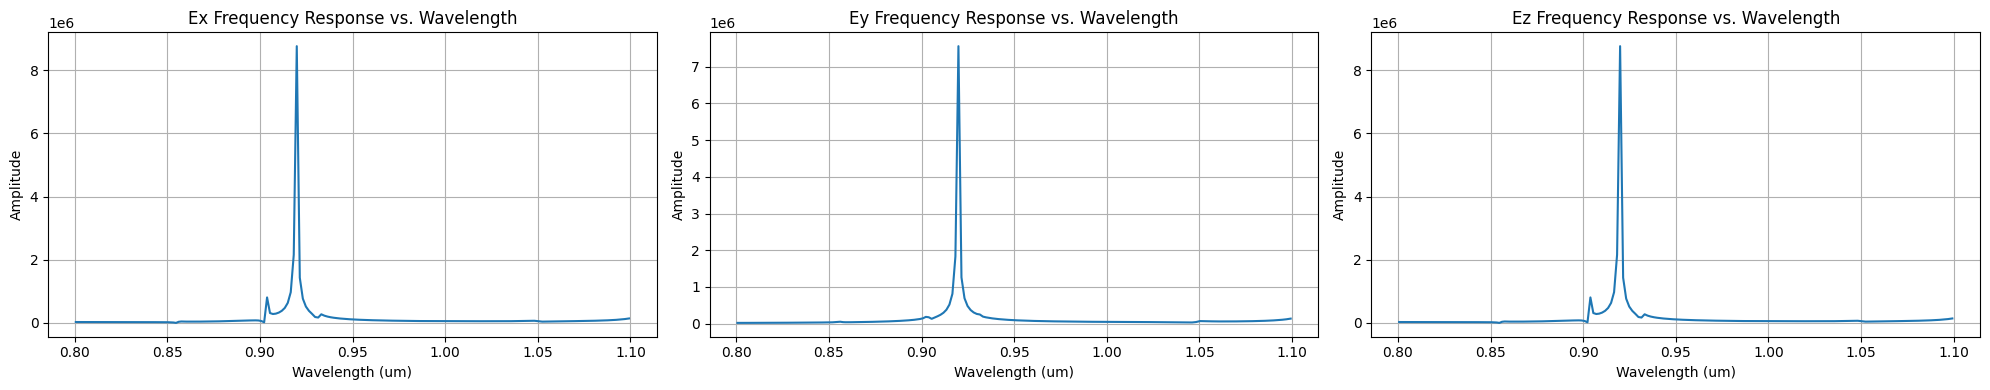

In [69]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

time_monitor_names = [monitor.name for monitor in time_monitors]

time_response_Ex = np.zeros_like(sim_data["time_monitor_1"].Ex.squeeze())
time_response_Ey = np.zeros_like(sim_data["time_monitor_1"].Ey.squeeze())
time_response_Ez = np.zeros_like(sim_data["time_monitor_1"].Ez.squeeze())

for monitor_name in time_monitor_names:
    time_response_Ex += sim_data[monitor_name].Ex.squeeze()
    time_response_Ey += sim_data[monitor_name].Ey.squeeze()
    time_response_Ez += sim_data[monitor_name].Ez.squeeze()

time_response_Ex /= len(time_monitor_names)
time_response_Ey /= len(time_monitor_names)
time_response_Ez /= len(time_monitor_names)


# Perform FFT and get the frequency response
freq_response_Ex = np.abs(np.fft.fft(time_response_Ex))
freq_response_Ey = np.abs(np.fft.fft(time_response_Ey))
freq_response_Ez = np.abs(np.fft.fft(time_response_Ez))

# Calculate the frequency values
freqs_Ex = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ex))
freqs_Ey = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ey))
freqs_Ez = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response_Ez))

# Calculate the corresponding wavelengths
wavelengths_Ex = td.constants.C_0 / freqs_Ex
wavelengths_Ey = td.constants.C_0 / freqs_Ey
wavelengths_Ez = td.constants.C_0 / freqs_Ez

# Select the indices within the monitor frequency range
plot_inds_Ex = np.where((monitor_freq[-1] < freqs_Ex) & (freqs_Ex < monitor_freq[0]))
plot_inds_Ey = np.where((monitor_freq[-1] < freqs_Ey) & (freqs_Ey < monitor_freq[0]))
plot_inds_Ez = np.where((monitor_freq[-1] < freqs_Ez) & (freqs_Ez < monitor_freq[0]))

# Plot the frequency response with respect to wavelength
ax[0].plot(wavelengths_Ex[plot_inds_Ex], freq_response_Ex[plot_inds_Ex])
ax[0].set_xlabel("Wavelength (um)")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Ex Frequency Response vs. Wavelength")
ax[0].grid(True)

ax[1].plot(wavelengths_Ey[plot_inds_Ey], freq_response_Ey[plot_inds_Ey])
ax[1].set_xlabel("Wavelength (um)")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Ey Frequency Response vs. Wavelength")
ax[1].grid(True)

ax[2].plot(wavelengths_Ex[plot_inds_Ez], freq_response_Ex[plot_inds_Ez])
ax[2].set_xlabel("Wavelength (um)")
ax[2].set_ylabel("Amplitude")
ax[2].set_title("Ez Frequency Response vs. Wavelength")
ax[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')
     

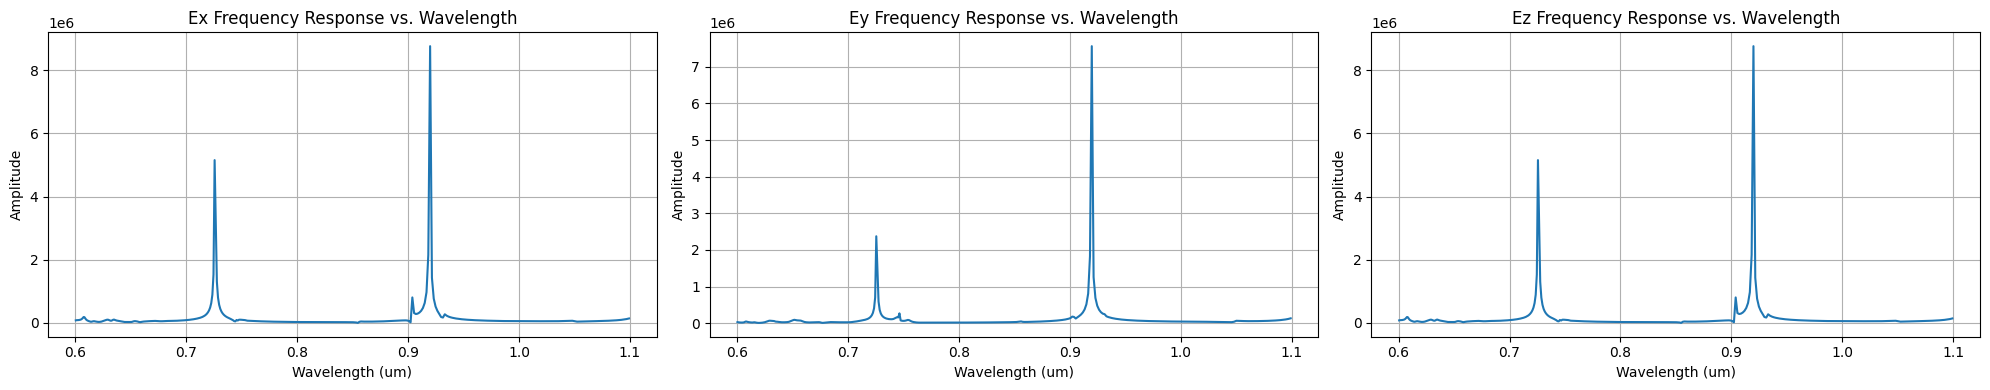

In [70]:
wavelength_short = np.array([0.6, 1.1])
freq_short = td.constants.C_0 / wavelength_short

plot_inds_Ex_short = np.where((freq_short[-1] < freqs_Ex) & (freqs_Ex < freq_short[0]))
plot_inds_Ey_short = np.where((freq_short[-1] < freqs_Ey) & (freqs_Ey < freq_short[0]))
plot_inds_Ez_short = np.where((freq_short[-1] < freqs_Ez) & (freqs_Ez < freq_short[0]))

fig, ax_short = plt.subplots(1, 3, tight_layout=True, figsize=(20, 4))

# Plot the frequency response with respect to wavelength
ax_short[0].plot(wavelengths_Ex[plot_inds_Ex_short], freq_response_Ex[plot_inds_Ex_short])
ax_short[0].set_xlabel("Wavelength (um)")
ax_short[0].set_ylabel("Amplitude")
ax_short[0].set_title("Ex Frequency Response vs. Wavelength")
ax_short[0].grid(True)

ax_short[1].plot(wavelengths_Ey[plot_inds_Ey_short], freq_response_Ey[plot_inds_Ey_short])
ax_short[1].set_xlabel("Wavelength (um)")
ax_short[1].set_ylabel("Amplitude")
ax_short[1].set_title("Ey Frequency Response vs. Wavelength")
ax_short[1].grid(True)

ax_short[2].plot(wavelengths_Ex[plot_inds_Ez_short], freq_response_Ex[plot_inds_Ez_short])
ax_short[2].set_xlabel("Wavelength (um)")
ax_short[2].set_ylabel("Amplitude")
ax_short[2].set_title("Ez Frequency Response vs. Wavelength")
ax_short[2].grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
#plt.savefig('Resonance_data')

plt.show()

In [71]:
t_final = 5.4e-12

In [72]:
sim_Q = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl = dl),
    run_time = t_final,
    sources = [dipole_source],
    monitors = time_monitors,
    structures = [slab, etch],
    medium = vacuum,
    shutoff = 1e-7,
    symmetry = [-1, 1, 0]
)

13:50:14 Eastern Standard Time WARNING: Structure at structures[1] was detected 
                               as being less than half of a central wavelength  
                               from a PML on side x-min. To avoid inaccurate    
                               results or divergence, please increase gap       
                               between any structures and PML or fully extend   
                               structure through the pml.                       

                               WARNING: Suppressed 3 WARNING messages.          